To do: 23.06.2023
    -read the explaination about encodings, maybe add extra covariants
    -add hyperparameter tuning with hyperopt 
    -add structure to run on spark cluster
    -try NLinear


Learnings Paper:
    -Larger look-back should be better e.g [24,720] data points. (Ruben used only 7. Don't know why)
    - 

Questions
    -What is the kernler size and the number of smaples? 
    -Did the timeindex that ruben used make any sense? I think this a very strange encodign. There should be somehting better
    -Should i use the eval set? Does that reduce overfitting? --> yes i think so
    -Why did the checkpointing not work?

In [13]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


#from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from darts                             import TimeSeries
from darts.models                      import DLinearModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


from pytorch_lightning.callbacks   import EarlyStopping
from darts.utils.likelihood_models import QuantileRegression
from torch.optim.lr_scheduler      import ReduceLROnPlateau
from torch.optim                   import Adam


In [14]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [15]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["total"] = pdf["Value_NE5"].values + pdf["Value_NE7"].values
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = int(len(pdf)*0.9)
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_15700\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,total
Timestamp,
2015-01-01,6.709087e+06
2015-01-02,7.073348e+06
2015-01-03,7.149544e+06
2015-01-04,6.724467e+06
2015-01-05,8.585045e+06
...,...
2023-06-15,7.271072e+06
2023-06-16,7.173852e+06
2023-06-17,6.233946e+06


In [16]:
series_scaler = Scaler()


ytrain = series_scaler.fit_transform(TimeSeries.from_dataframe(pdf_train))
ytest  = series_scaler.fit_transform(TimeSeries.from_dataframe(pdf_test))
ytotal = series_scaler.fit_transform(TimeSeries.from_dataframe(pdf))
ytotal


<TimeSeries (DataArray) (Timestamp: 3092, component: 1, sample: 1)>
array([[[0.32585622]],

       [[0.41890086]],

       [[0.438364  ]],

       ...,

       [[0.20448893]],

       [[0.1139864 ]],

       [[0.36642058]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-06-19
  * component  (component) object 'total'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [29]:
model = DLinearModel(
                    input_chunk_length = 2*365,
                    output_chunk_length = 365,
                    model_name = 'testModel',
                    kernel_size=25, #default 25
                    random_state=16,
                    lr_scheduler_kwargs= {"optimizer": Adam, "threshold": 0.0001, "verbose": True, 'min_lr':1e-6, 'factor':0.5, 'threshold_mode':'abs'},
                    optimizer_kwargs={'lr': 1e-3},
                    #save_checkpoints=True,
                    #force_reset=True, Default is false
                    )

#lr_scheduler_cls = ReduceLROnPlateau, only works if validations series is used in fit().

model.fit(series=ytotal,epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 266 K 
5 | linear_trend    | Linear           | 266 K 
-----------------------------------------------------
533 K     Trainable params
0         Non-trainable params
533 K     Total params
2.135     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=730, output_chunk_length=365, model_name=testModel, random_state=16, lr_scheduler_kwargs={'optimizer': <class 'torch.optim.adam.Adam'>, 'threshold': 0.0001, 'verbose': True, 'min_lr': 1e-06, 'factor': 0.5, 'threshold_mode': 'abs'}, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, force_reset=True)

In [30]:
y_pred = model.predict(n=int(1.5*len(ytest)), series=ytrain)
y_pred = series_scaler.inverse_transform(y_pred).pd_series()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

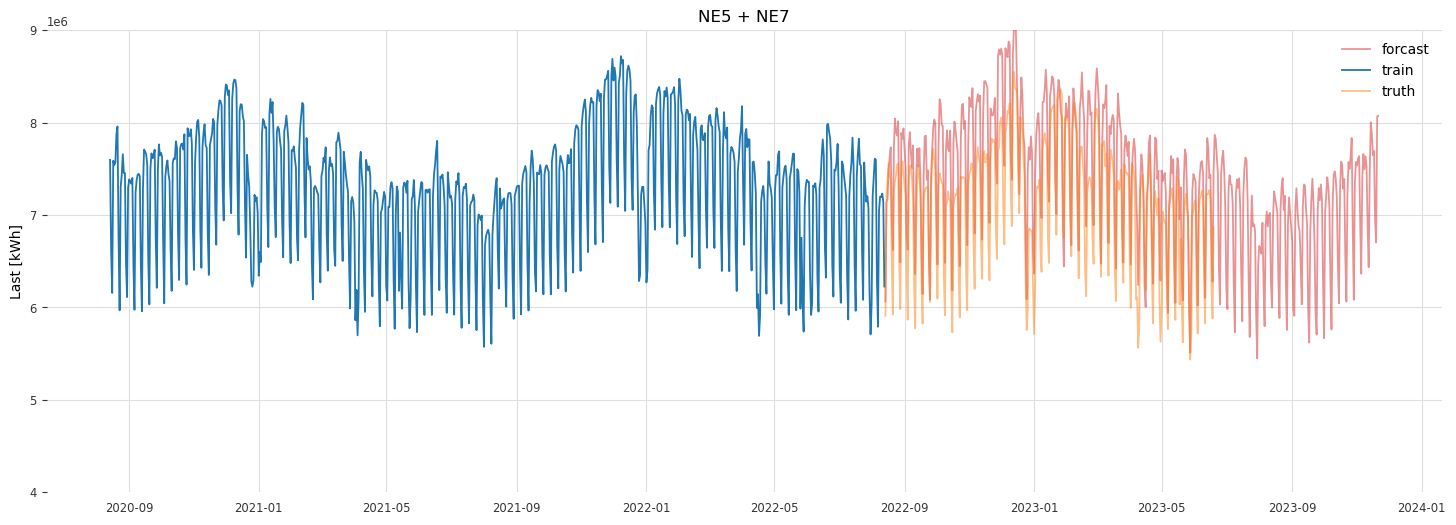

In [31]:
plt.figure(figsize=(18, 6))

plt.plot(y_pred, color="tab:red", label="forcast", alpha=0.5)
plt.plot(pdf_train[-2*365:], color="tab:blue", label="train")
plt.plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
plt.legend()
plt.title("NE5 + NE7")
plt.ylabel("Last [kWh]")
plt.ylim(4e6, 9e6)
plt.show()
